All codes in the rest use **`cleaned_complete_data_Face_Verification_Info_Raady2.csv`** as the cleaned dataset prepared in the **Data_Cleaning.ipynb** file.  

# 📰 Multi-Modal News Outlet Classification  

This code block builds a **multi-modal deep learning model** to classify news outlets by combining **visual content, facial identity features, and structured metadata**. The framework integrates:  
- **Image features** from ResNet101 (article-level visual context).  
- **Face embeddings** from cropped faces (MTCNN for detection, InceptionResnetV1 for identity encoding).  
- **Structured metadata**: political figures, party affiliation, publication date, and latent topics (LDA).  

By fusing these heterogeneous signals with embeddings and attention-based layers, the model leverages both **who appears in the news** and **what is being discussed**, leading to stronger classification than unimodal baselines.  

### Pipeline  
1. **Data prep**: stratified split, label encoding, LDA topics.  
2. **Dataset**: loads image + cropped face embedding + metadata.  
3. **Model**: fusion of ResNet, FaceNet, and structured embeddings with multi-head attention.  
4. **Training**: AdamW, CrossEntropyLoss (label smoothing), checkpointing & metrics visualization.  

Run training:  
```python
train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=50, device=device)


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import gensim
from gensim import corpora
from torchvision import models, transforms
from PIL import Image
import requests
from io import BytesIO
import torch_optimizer as optim
import numpy as np
import ast
from sklearn.utils.class_weight import compute_class_weight
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch.optim as optim
import random

seed = 422
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

random_seed = 422

mtcnn = MTCNN(keep_all=False, device=torch.device('cpu'), thresholds=[0.4, 0.5, 0.6], min_face_size=15, factor=0.6)

df = pd.read_csv('data/cleaned_complete_data_Face_Verification_Info_Raady2.csv')
df['dataset_type'] = 'train'
df['prediction'] = None
df['stratify_col'] = df['News Center'] + '_' + df['Top1_Person']
group_counts = df['stratify_col'].value_counts()
sufficient_groups = group_counts[group_counts >= 2].index
df = df[df['stratify_col'].isin(sufficient_groups)]
train_df, val_df = train_test_split(df, test_size=0.15, stratify=df['stratify_col'], random_state=random_seed)
train_df['dataset_type'] = 'train'
val_df['dataset_type'] = 'val'
df = pd.concat([train_df, val_df], ignore_index=True)
df.drop(columns=['stratify_col'], inplace=True)

print("Training set details:")
print(f"Number of 'News Center' categories: {train_df['News Center'].nunique()}")
print(f"Number of 'Top1_Person' categories: {train_df['Top1_Person'].nunique()}")
print(f"Number of 'Real Person Side' categories: {train_df['Real Person Side'].nunique()}")
print(f"Number of 'Date' categories: {train_df['Date'].nunique()}")

print("\nValidation set details:")
print(f"Number of 'News Center' categories: {val_df['News Center'].nunique()}")
print(f"Number of 'Top1_Person' categories: {val_df['Top1_Person'].nunique()}")
print(f"Number of 'Real Person Side' categories: {val_df['Real Person Side'].nunique()}")
print(f"Number of 'Date' categories: {val_df['Date'].nunique()}")

df.to_pickle('data/cleaned_complete_data_Face_Verification_Info_Raady_MLModel.pkl')

num_person_categories = df['Top1_Person'].nunique()
num_party_categories = df['Real Person Side'].nunique()
num_topics = len([col for col in df.columns if col.startswith('topic_')])
num_classes = df['News Center'].nunique()
num_date_categories = df['Date'].nunique()

class NewsDataset(Dataset):
    def __init__(self, dataframe, image_dir='data/images_Polarization', transform=None, face_transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform
        self.face_transform = face_transform
        self.person_encoder = LabelEncoder()
        self.outlet_encoder = LabelEncoder()
        self.party_encoder = LabelEncoder()
        self.date_encoder = LabelEncoder()
        self.person_encoder.fit(dataframe['Top1_Person'])
        self.outlet_encoder.fit(dataframe['News Center'])
        self.party_encoder.fit(dataframe['Real Person Side'])
        self.date_encoder.fit(dataframe['Date'])
        self.person_encoded = self.person_encoder.transform(dataframe['Top1_Person'])
        self.outlet_encoded = self.outlet_encoder.transform(dataframe['News Center'])
        self.party_encoded = self.party_encoder.transform(dataframe['Real Person Side'])
        self.topic_columns = [col for col in dataframe.columns if col.startswith('topic_')]
        self.dates = self.date_encoder.transform(dataframe['Date'])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_id = self.dataframe.iloc[idx]['ID']
        img_path = os.path.join(self.image_dir, f"{img_id}.jpg")
        img = Image.open(img_path).convert('RGB')
        face_img = mtcnn(img)
        if face_img is None:
            face_img = transforms.Resize((224, 224))(img)
            face_img = transforms.ToTensor()(face_img)
        else:
            face_img = transforms.Resize((224, 224))(face_img)
        if self.transform:
            img = self.transform(img)
        if self.face_transform:
            face_img = self.face_transform(face_img)
        label = self.outlet_encoded[idx]
        person = self.person_encoded[idx]
        party = self.party_encoded[idx]
        date = torch.tensor(self.dates[idx], dtype=torch.long)
        topic_distribution = self.dataframe.iloc[idx][self.topic_columns].values
        topic_distribution = np.array(topic_distribution, dtype=np.float32)
        topic_distribution = torch.tensor(topic_distribution)
        return img, face_img, torch.tensor(label, dtype=torch.long), torch.tensor(person, dtype=torch.long), torch.tensor(party, dtype=torch.long), topic_distribution, date

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

face_transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

train_dataset = NewsDataset(train_df, transform=transform)
val_dataset = NewsDataset(val_df, transform=transform)
num_workers = 30
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=num_workers)

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(MultiHeadAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads
        assert self.head_dim * heads == embed_size
        self.values = nn.Linear(embed_size, embed_size, bias=False)
        self.keys = nn.Linear(embed_size, embed_size, bias=False)
        self.queries = nn.Linear(embed_size, embed_size, bias=False)
        self.fc_out = nn.Linear(embed_size, embed_size)

    def forward(self, values, keys, query):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]
        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(query)
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = queries.reshape(N, query_len, self.heads, self.head_dim)
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        attention = torch.nn.functional.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)
        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(N, query_len, self.heads * self.head_dim)
        out = self.fc_out(out)
        return out

class ImprovedMultiModalModel(nn.Module):
    def __init__(self, num_person_categories, num_party_categories, num_topics, num_classes,
                 num_date_categories, embedding_dim_person=8, embedding_dim_party=2,
                 embedding_dim_date=4, num_attention_heads=8, window_size=32):
        super(ImprovedMultiModalModel, self).__init__()
        self.face_vgg = InceptionResnetV1(pretrained='vggface2').eval()
        for param in list(self.face_vgg.parameters())[:-5]:
            param.requires_grad = False
        self.fc_vgg_1 = nn.Linear(512, 256)
        self.bn_vgg = nn.BatchNorm1d(256)
        self.dropout_vgg = nn.Dropout(0.3)
        self.person_embedding = nn.Embedding(num_person_categories, embedding_dim_person)
        self.party_embedding = nn.Embedding(num_party_categories, embedding_dim_party)
        self.date_embedding = nn.Embedding(num_date_categories, embedding_dim_date)
        self.fc_structured_proj = nn.Linear(embedding_dim_person + embedding_dim_party + num_topics + embedding_dim_date, 64)
        self.structured_attention = MultiHeadAttention(embed_size=64, heads=num_attention_heads)
        self.bn_structured = nn.BatchNorm1d(64)
        self.dropout_structured = nn.Dropout(0.4)
        self.fc_person_party_proj = nn.Linear(embedding_dim_person + embedding_dim_party, window_size)
        self.chunked_attention = MultiHeadAttention(embed_size=window_size, heads=num_attention_heads)
        resnet_pretrained = models.resnet101(pretrained=True)
        for param in list(resnet_pretrained.parameters())[:-10]:
            param.requires_grad = False
        self.features_resnet = nn.Sequential(*list(resnet_pretrained.children())[:-1])
        self.fc_resnet = nn.Linear(resnet_pretrained.fc.in_features, 512)
        self.bn_resnet = nn.BatchNorm1d(512)
        self.dropout_resnet = nn.Dropout(0.6)
        self.fc_out = nn.Linear(256 + 64 + 512, num_classes)
        self.dropout_out = nn.Dropout(0.5)

    def forward(self, resnet_img, face_img, person, party, topic_distribution, date):
        vgg_features = self.face_vgg(face_img)
        vgg_features = F.relu(self.bn_vgg(self.fc_vgg_1(vgg_features)))
        vgg_features = self.dropout_vgg(vgg_features)
        person_embedded = self.person_embedding(person)
        party_embedded = self.party_embedding(party)
        date_embedded = self.date_embedding(date)
        structured_data = torch.cat((person_embedded, party_embedded, topic_distribution, date_embedded), dim=1)
        structured_data_proj = F.relu(self.fc_structured_proj(structured_data))
        structured_data = self.structured_attention(structured_data_proj.unsqueeze(1), structured_data_proj.unsqueeze(1), structured_data_proj.unsqueeze(1)).squeeze(1)
        structured_data = F.relu(self.bn_structured(structured_data))
        structured_data = self.dropout_structured(structured_data)
        person_party_data = torch.cat((person_embedded, party_embedded), dim=1)
        person_party_proj = self.fc_person_party_proj(person_party_data).unsqueeze(1)
        vgg_chunks = vgg_features.view(vgg_features.size(0), 8, -1)
        attended_chunks = []
        for i in range(8):
            vgg_chunk = vgg_chunks[:, i, :].unsqueeze(1)
            attention_out = self.chunked_attention(person_party_proj, vgg_chunk, vgg_chunk).squeeze(1)
            attended_chunks.append(attention_out)
        attended_vgg_features = torch.cat(attended_chunks, dim=1)
        resnet_features = self.features_resnet(resnet_img)
        resnet_features = torch.flatten(resnet_features, 1)
        resnet_features = F.relu(self.bn_resnet(self.fc_resnet(resnet_features)))
        resnet_features = self.dropout_resnet(resnet_features)
        combined_features = torch.cat((attended_vgg_features, structured_data, resnet_features), dim=1)
        combined_features = self.dropout_out(combined_features)
        out = self.fc_out(combined_features)
        return out

embedding_dim_person = 8
embedding_dim_party = 2
embedding_dim_date = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ImprovedMultiModalModel(
    num_person_categories=num_person_categories,
    num_party_categories=num_party_categories,
    num_topics=num_topics,
    num_classes=num_classes,
    num_date_categories=num_date_categories,
    embedding_dim_person=embedding_dim_person,
    embedding_dim_party=embedding_dim_party,
    embedding_dim_date=embedding_dim_date,
    num_attention_heads=8
)
model = model.to(device)

class_weights = compute_class_weight('balanced', classes=np.unique(df['News Center']), y=df['News Center'])
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)
#criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.03)
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, device, save_path='model/model_checkpoint'):
    epoch_train_acc = []
    epoch_val_acc = []
    epoch_train_losses = []
    epoch_val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        running_train_correct = 0
        running_train_total = 0
        train_progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} Training', unit='batch')
        for img, face_img, label, person, party, topic_distribution, date in train_progress_bar:
            img = img.to(device)
            face_img = face_img.to(device)
            person = person.to(device)
            party = party.to(device)
            topic_distribution = topic_distribution.to(device)
            date = date.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            outputs = model(img, face_img, person, party, topic_distribution, date)
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * label.size(0)
            _, preds = torch.max(outputs, 1)
            running_train_correct += torch.sum(preds == label).item()
            running_train_total += label.size(0)
        avg_train_loss = running_train_loss / running_train_total
        avg_train_acc = running_train_correct / running_train_total
        epoch_train_losses.append(avg_train_loss)
        epoch_train_acc.append(avg_train_acc)
        model.eval()
        running_val_loss = 0.0
        running_val_correct = 0
        running_val_total = 0
        val_progress_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} Validation', unit='batch')
        with torch.no_grad():
            for img, face_img, label, person, party, topic_distribution, date in val_progress_bar:
                img = img.to(device)
                face_img = face_img.to(device)
                person = person.to(device)
                party = party.to(device)
                topic_distribution = topic_distribution.to(device)
                date = date.to(device)
                label = label.to(device)
                outputs = model(img, face_img, person, party, topic_distribution, date)
                val_loss = criterion(outputs, label)
                running_val_loss += val_loss.item() * label.size(0)
                _, preds = torch.max(outputs, 1)
                running_val_correct += torch.sum(preds == label).item()
                running_val_total += label.size(0)
        avg_val_loss = running_val_loss / running_val_total
        avg_val_acc = running_val_correct / running_val_total
        epoch_val_losses.append(avg_val_loss)
        epoch_val_acc.append(avg_val_acc)
        os.makedirs(save_path, exist_ok=True)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'train_acc': avg_train_acc,
            'val_loss': avg_val_loss,
            'val_acc': avg_val_acc
        }, os.path.join(save_path, f'epoch_{epoch}.pth'))
        plt.figure(figsize=(14, 5))
        plt.subplot(1, 2, 1)
        plt.plot(range(1, epoch+2), epoch_train_acc, 'bo-', label='Train Accuracy')
        plt.plot(range(1, epoch+2), epoch_val_acc, 'ro-', label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(range(1, epoch+2), epoch_train_losses, 'bo-', label='Training Loss')
        plt.plot(range(1, epoch+2), epoch_val_losses, 'ro-', label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=50, device=device)

# 📰 Multi-Modal News Classifier Performance 

Given a trained model, this script loads data, applies the model (images + faces + metadata), and outputs predictions, probabilities, and evaluation metrics.  

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image
import numpy as np
from facenet_pytorch import InceptionResnetV1
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(MultiHeadAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads
        assert self.head_dim * heads == embed_size
        self.values = nn.Linear(embed_size, embed_size, bias=False)
        self.keys = nn.Linear(embed_size, embed_size, bias=False)
        self.queries = nn.Linear(embed_size, embed_size, bias=False)
        self.fc_out = nn.Linear(embed_size, embed_size)

    def forward(self, values, keys, query):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]
        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(query)
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = queries.reshape(N, query_len, self.heads, self.head_dim)
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        attention = torch.nn.functional.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)
        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(N, query_len, self.heads * self.head_dim)
        out = self.fc_out(out)
        return out


class ImprovedMultiModalModel(nn.Module):
    def __init__(self, num_person_categories, num_party_categories, num_topics, num_classes,
                 num_date_categories, embedding_dim_person=8, embedding_dim_party=2,
                 embedding_dim_date=4, num_attention_heads=8, window_size=32):
        super(ImprovedMultiModalModel, self).__init__()
        self.face_vgg = InceptionResnetV1(pretrained='vggface2').eval()
        for param in list(self.face_vgg.parameters())[:-5]:
            param.requires_grad = False
        self.fc_vgg_1 = nn.Linear(512, 256)
        self.bn_vgg = nn.BatchNorm1d(256)
        self.dropout_vgg = nn.Dropout(0.3)

        self.person_embedding = nn.Embedding(num_person_categories, embedding_dim_person)
        self.party_embedding = nn.Embedding(num_party_categories, embedding_dim_party)
        self.date_embedding = nn.Embedding(num_date_categories, embedding_dim_date)

        self.fc_structured_proj = nn.Linear(embedding_dim_person + embedding_dim_party + num_topics + embedding_dim_date, 64)
        self.structured_attention = MultiHeadAttention(embed_size=64, heads=num_attention_heads)
        self.bn_structured = nn.BatchNorm1d(64)
        self.dropout_structured = nn.Dropout(0.4)

        self.fc_person_party_proj = nn.Linear(embedding_dim_person + embedding_dim_party, window_size)
        self.chunked_attention = MultiHeadAttention(embed_size=window_size, heads=num_attention_heads)

        resnet_pretrained = models.resnet101(pretrained=True)
        for param in list(resnet_pretrained.parameters())[:-10]:
            param.requires_grad = False
        self.features_resnet = nn.Sequential(*list(resnet_pretrained.children())[:-1])
        self.fc_resnet = nn.Linear(resnet_pretrained.fc.in_features, 512)
        self.bn_resnet = nn.BatchNorm1d(512)
        self.dropout_resnet = nn.Dropout(0.6)

        self.fc_out = nn.Linear(256 + 64 + 512, num_classes)
        self.dropout_out = nn.Dropout(0.5)

    def forward(self, resnet_img, face_img, person, party, topic_distribution, date):
        vgg_features = self.face_vgg(face_img)
        vgg_features = F.relu(self.bn_vgg(self.fc_vgg_1(vgg_features)))
        vgg_features = self.dropout_vgg(vgg_features)

        person_embedded = self.person_embedding(person)
        party_embedded = self.party_embedding(party)
        date_embedded = self.date_embedding(date)

        structured_data = torch.cat((person_embedded, party_embedded, topic_distribution, date_embedded), dim=1)
        structured_data_proj = F.relu(self.fc_structured_proj(structured_data))
        structured_data = self.structured_attention(structured_data_proj.unsqueeze(1), structured_data_proj.unsqueeze(1), structured_data_proj.unsqueeze(1)).squeeze(1)
        structured_data = F.relu(self.bn_structured(structured_data))
        structured_data = self.dropout_structured(structured_data)

        person_party_data = torch.cat((person_embedded, party_embedded), dim=1)
        person_party_proj = self.fc_person_party_proj(person_party_data).unsqueeze(1)

        vgg_chunks = vgg_features.view(vgg_features.size(0), 8, -1)
        attended_chunks = []
        for i in range(8):
            vgg_chunk = vgg_chunks[:, i, :].unsqueeze(1)
            attention_out = self.chunked_attention(person_party_proj, vgg_chunk, vgg_chunk).squeeze(1)
            attended_chunks.append(attention_out)
        attended_vgg_features = torch.cat(attended_chunks, dim=1)

        resnet_features = self.features_resnet(resnet_img)
        resnet_features = torch.flatten(resnet_features, 1)
        resnet_features = F.relu(self.bn_resnet(self.fc_resnet(resnet_features)))
        resnet_features = self.dropout_resnet(resnet_features)

        combined_features = torch.cat((attended_vgg_features, structured_data, resnet_features), dim=1)
        combined_features = self.dropout_out(combined_features)
        out = self.fc_out(combined_features)
        return out


class FullDataset(Dataset):
    def __init__(self, dataframe, image_dir='data/images_Polarization', transform=None, face_transform=None, mtcnn=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform
        self.face_transform = face_transform
        self.mtcnn = mtcnn
        self.person_encoder = LabelEncoder()
        self.outlet_encoder = LabelEncoder()
        self.party_encoder = LabelEncoder()
        self.date_encoder = LabelEncoder()
        self.person_encoder.fit(dataframe['Top1_Person'])
        self.outlet_encoder.fit(dataframe['News Center'])
        self.party_encoder.fit(dataframe['Real Person Side'])
        self.date_encoder.fit(dataframe['Date'])
        self.person_encoded = self.person_encoder.transform(dataframe['Top1_Person'])
        self.outlet_encoded = self.outlet_encoder.transform(dataframe['News Center'])
        self.party_encoded = self.party_encoder.transform(dataframe['Real Person Side'])
        self.topic_columns = [col for col in dataframe.columns if col.startswith('topic_')]
        self.dates = self.date_encoder.transform(dataframe['Date'])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_id = self.dataframe.iloc[idx]['ID']
        img_path = os.path.join(self.image_dir, f"{img_id}.jpg")
        img = Image.open(img_path).convert('RGB')
        resnet_img = self.transform(img) if self.transform else transforms.ToTensor()(img)
        face_img = None
        if self.mtcnn is not None:
            face_img = self.mtcnn(img)
        if face_img is None:
            face_img = transforms.Resize((160, 160))(img)
            face_img = transforms.ToTensor()(face_img)
        if self.face_transform:
            if isinstance(face_img, Image.Image):
                face_img = self.face_transform(face_img)
            elif isinstance(face_img, torch.Tensor):
                for t in self.face_transform.transforms:
                    if not isinstance(t, transforms.ToTensor):
                        face_img = t(face_img)
        label = torch.tensor(self.outlet_encoded[idx], dtype=torch.long)
        person = torch.tensor(self.person_encoded[idx], dtype=torch.long)
        party = torch.tensor(self.party_encoded[idx], dtype=torch.long)
        date = torch.tensor(self.dates[idx], dtype=torch.long)
        topic_distribution = self.dataframe.iloc[idx][self.topic_columns].values.astype(np.float32)
        topic_distribution = torch.tensor(topic_distribution)
        return resnet_img, face_img, label, person, party, topic_distribution, date


df = pd.read_pickle('data/cleaned_complete_data_Face_Verification_Info_Raady_MLModel.pkl')
checkpoint_path = f'model/ML_Model.pth'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

face_transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
])

num_workers = 10
full_dataset = FullDataset(df, transform=transform, face_transform=face_transform)
full_loader = DataLoader(full_dataset, batch_size=64, shuffle=False, num_workers=num_workers)

person_encoder = LabelEncoder()
party_encoder = LabelEncoder()
date_encoder = LabelEncoder()
outlet_encoder = LabelEncoder()
person_encoder.fit(df['Top1_Person'])
party_encoder.fit(df['Real Person Side'])
date_encoder.fit(df['Date'])
outlet_encoder.fit(df['News Center'])

num_person_categories = len(person_encoder.classes_)
num_party_categories = len(party_encoder.classes_)
num_date_categories = len(date_encoder.classes_)
num_classes = len(outlet_encoder.classes_)
num_topics = 40


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ImprovedMultiModalModel(
    num_person_categories=num_person_categories,
    num_party_categories=num_party_categories,
    num_topics=num_topics,
    num_classes=num_classes,
    num_date_categories=num_date_categories,
    embedding_dim_person=8,
    embedding_dim_party=2,
    embedding_dim_date=4,
    num_attention_heads=8
)
model.to(device)
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

def get_predictions_and_probs(model, dataloader, device):
    model.eval()
    all_predictions, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for img, face_img, label, person, party, topic_distribution, date in tqdm(dataloader, desc="Evaluating"):
            img, face_img = img.to(device), face_img.to(device)
            person, party, topic_distribution, date, label = (
                person.to(device), party.to(device),
                topic_distribution.to(device), date.to(device),
                label.to(device)
            )
            outputs = model(img, face_img, person, party, topic_distribution, date)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(label.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    return all_predictions, all_labels, all_probs

predictions, labels, probs = get_predictions_and_probs(model, full_loader, device)


label_encoder = LabelEncoder()
label_encoder.fit(df['News Center'])
decoded_predictions = label_encoder.inverse_transform(predictions)
df['Model_Prediction'] = decoded_predictions
df['Correct_Prediction'] = (df['Model_Prediction'] == df['News Center']).map({True: 'Yes', False: 'No'})
prob_column_names = [f'prob_{class_name}' for class_name in label_encoder.classes_]
prob_df = pd.DataFrame(probs, columns=prob_column_names)
df = pd.concat([df, prob_df], axis=1)

for subset in ['val']:
    subset_df = df[df['dataset_type'] == subset]
    y_true = subset_df['News Center'].values
    y_pred = subset_df['Model_Prediction'].values
    print(f"\n=== {subset.upper()} SET ===")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
    cm = confusion_matrix(y_true, y_pred, labels=label_encoder.classes_)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f"Confusion Matrix - {subset.capitalize()} Set")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# ⚖️ Counterfactual Prediction Pipeline  

This code evaluates how introducing a **counterfactual change** (adding a *smile* to politician images) shifts news outlet classification probabilities.

### Steps
1. **Load Validation Data**  
   - Encoded persons, parties, dates, and outlets from the preprocessed dataset.  
   - Built two datasets: with-smile vs. without-smile images.  

2. **Model Inference**  
   - For the checkpointed model, predictions are made separately on with-smile and without-smile datasets.  
   - For each politician, three image samples are processed, extracting outlet probabilities.  

3. **Probability Comparison**  
   - Probabilities are saved for each outlet under both conditions.  
   - A metric are computed per outlet:  
     - **Ratio (log change)**: log(counterfactual/factual) relative to Reuters baseline.  

4. **Results Storage**  
   - Combined DataFrame includes original metadata, per-image probabilities, ratios, and differences.  
   - Final outputs (`Final_Ratio`) summarize mean counterfactual shifts across the three images.  
   - Saved to `Probs_Smile_Finalized_Compelete.csv`.  


In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image, UnidentifiedImageError
import requests
from io import BytesIO
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt
import gensim
from gensim import corpora
from torchvision import models
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
from facenet_pytorch import InceptionResnetV1, MTCNN


class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(MultiHeadAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads
        assert self.head_dim * heads == embed_size
        self.values = nn.Linear(embed_size, embed_size, bias=False)
        self.keys = nn.Linear(embed_size, embed_size, bias=False)
        self.queries = nn.Linear(embed_size, embed_size, bias=False)
        self.fc_out = nn.Linear(embed_size, embed_size)

    def forward(self, values, keys, query):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]
        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(query)
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = queries.reshape(N, query_len, self.heads, self.head_dim)
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        attention = torch.nn.functional.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)
        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )
        out = self.fc_out(out)
        return out


class ImprovedMultiModalModel(nn.Module):
    def __init__(self, num_person_categories, num_party_categories, num_topics, num_classes,
                 num_date_categories, embedding_dim_person=8, embedding_dim_party=2,
                 embedding_dim_date=4, num_attention_heads=8, window_size=32):
        super(ImprovedMultiModalModel, self).__init__()
        self.face_vgg = InceptionResnetV1(pretrained='vggface2').eval()
        for param in list(self.face_vgg.parameters())[:-5]:
            param.requires_grad = False
        self.fc_vgg_1 = nn.Linear(512, 256)
        self.bn_vgg = nn.BatchNorm1d(256)
        self.dropout_vgg = nn.Dropout(0.3)
        self.person_embedding = nn.Embedding(num_person_categories, embedding_dim_person)
        self.party_embedding = nn.Embedding(num_party_categories, embedding_dim_party)
        self.date_embedding = nn.Embedding(num_date_categories, embedding_dim_date)
        self.fc_structured_proj = nn.Linear(embedding_dim_person + embedding_dim_party + num_topics + embedding_dim_date, 64)
        self.structured_attention = MultiHeadAttention(embed_size=64, heads=num_attention_heads)
        self.bn_structured = nn.BatchNorm1d(64)
        self.dropout_structured = nn.Dropout(0.4)
        self.fc_person_party_proj = nn.Linear(embedding_dim_person + embedding_dim_party, window_size)
        self.chunked_attention = MultiHeadAttention(embed_size=window_size, heads=num_attention_heads)
        resnet_pretrained = models.resnet101(pretrained=True)
        for param in list(resnet_pretrained.parameters())[:-10]:
            param.requires_grad = False
        self.features_resnet = nn.Sequential(*list(resnet_pretrained.children())[:-1])
        self.fc_resnet = nn.Linear(resnet_pretrained.fc.in_features, 512)
        self.bn_resnet = nn.BatchNorm1d(512)
        self.dropout_resnet = nn.Dropout(0.6)
        self.fc_out = nn.Linear(256 + 64 + 512, num_classes)
        self.dropout_out = nn.Dropout(0.5)

    def forward(self, resnet_img, face_img, person, party, topic_distribution, date):
        vgg_features = self.face_vgg(face_img)
        vgg_features = F.relu(self.bn_vgg(self.fc_vgg_1(vgg_features)))
        vgg_features = self.dropout_vgg(vgg_features)
        person_embedded = self.person_embedding(person)
        party_embedded = self.party_embedding(party)
        date_embedded = self.date_embedding(date)
        structured_data = torch.cat((person_embedded, party_embedded, topic_distribution, date_embedded), dim=1)
        structured_data_proj = F.relu(self.fc_structured_proj(structured_data))
        structured_data = self.structured_attention(structured_data_proj.unsqueeze(1), structured_data_proj.unsqueeze(1), structured_data_proj.unsqueeze(1)).squeeze(1)
        structured_data = F.relu(self.bn_structured(structured_data))
        structured_data = self.dropout_structured(structured_data)
        person_party_data = torch.cat((person_embedded, party_embedded), dim=1)
        person_party_proj = self.fc_person_party_proj(person_party_data).unsqueeze(1)
        vgg_chunks = vgg_features.view(vgg_features.size(0), 8, -1)
        attended_chunks = []
        for i in range(8):
            vgg_chunk = vgg_chunks[:, i, :].unsqueeze(1)
            attention_out = self.chunked_attention(person_party_proj, vgg_chunk, vgg_chunk).squeeze(1)
            attended_chunks.append(attention_out)
        attended_vgg_features = torch.cat(attended_chunks, dim=1)
        resnet_features = self.features_resnet(resnet_img)
        resnet_features = torch.flatten(resnet_features, 1)
        resnet_features = F.relu(self.bn_resnet(self.fc_resnet(resnet_features)))
        resnet_features = self.dropout_resnet(resnet_features)
        combined_features = torch.cat((attended_vgg_features, structured_data, resnet_features), dim=1)
        combined_features = self.dropout_out(combined_features)
        out = self.fc_out(combined_features)
        return out


df = pd.read_pickle('data/cleaned_complete_data_Face_Verification_Info_Raady_MLModel.pkl')
df = df[df['dataset_type'] == 'val'].reset_index(drop=True)

unique_persons = df['Top1_Person'].nunique()
num_person_categories = unique_persons
num_party_categories = 2
num_topics = 40
num_date_features = len([col for col in df.columns if col.startswith('Date_')])
num_classes = len(df['News Center'].unique())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_attention_layers = 1

person_encoder = LabelEncoder()
party_encoder = LabelEncoder()
date_encoder = LabelEncoder()
outlet_encoder = LabelEncoder()
person_encoder.fit(df['Top1_Person'])
party_encoder.fit(df['Real Person Side'])
date_encoder.fit(df['Date'])
outlet_encoder.fit(df['News Center'])
df['person_encoded'] = person_encoder.transform(df['Top1_Person'])
df['party_encoded'] = party_encoder.transform(df['Real Person Side'])
df['date_encoded'] = date_encoder.transform(df['Date'])
df['outlet_encoded'] = outlet_encoder.transform(df['News Center'])
num_person_categories = len(person_encoder.classes_)
num_party_categories = len(party_encoder.classes_)
num_date_categories = len(date_encoder.classes_)
num_classes = len(outlet_encoder.classes_)
num_topics = 40
embedding_dim_person = 8
embedding_dim_party = 2
embedding_dim_date = 4
model = ImprovedMultiModalModel(
    num_person_categories=num_person_categories,
    num_party_categories=num_party_categories,
    num_topics=num_topics,
    num_classes=num_classes,
    num_date_categories=num_date_categories,
    embedding_dim_person=embedding_dim_person,
    embedding_dim_party=embedding_dim_party,
    embedding_dim_date=embedding_dim_date,
    num_attention_heads=8
)


class AdaptedStaticImageDataset(Dataset):
    def __init__(self, dataframe, image_dir='Counterfactuals', transform=None, face_transform=None, smile=False, num_images=3):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform
        self.face_transform = face_transform
        self.smile = smile
        self.num_images = num_images
        self.mtcnn = MTCNN(keep_all=False, device=torch.device('cpu'), thresholds=[0.4, 0.5, 0.6], min_face_size=15, factor=0.6)
        self.person_encoder = LabelEncoder()
        self.outlet_encoder = LabelEncoder()
        self.party_encoder = LabelEncoder()
        self.date_encoder = LabelEncoder()
        self.person_encoder.fit(dataframe['Top1_Person'])
        self.outlet_encoder.fit(dataframe['News Center'])
        self.party_encoder.fit(dataframe['Real Person Side'])
        self.date_encoder.fit(dataframe['Date'])
        self.person_encoded = self.person_encoder.transform(dataframe['Top1_Person'])
        self.outlet_encoded = self.outlet_encoder.transform(dataframe['News Center'])
        self.party_encoded = self.party_encoder.transform(dataframe['Real Person Side'])
        self.dates = self.date_encoder.transform(dataframe['Date'])
        self.topic_columns = [col for col in dataframe.columns if col.startswith('topic_')]

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        politician = self.dataframe.iloc[idx]['Top1_Person'].replace(' ', '_')
        img_suffix = '_with_smile' if self.smile else ''
        images = []
        face_images = []
        for i in range(1, self.num_images + 1):
            img_path = os.path.join(self.image_dir, f"{politician}{img_suffix}_{i}.jpg")
            try:
                img = Image.open(img_path).convert('RGB')
                face_img = self.mtcnn(img)
                if face_img is None:
                    face_img = transforms.Resize((224, 224))(img)
                    face_img = transforms.ToPILImage()(face_img)
                else:
                    face_img = transforms.Resize((224, 224))(face_img)
                    face_img = transforms.ToPILImage()(face_img)
                if self.transform:
                    img = self.transform(img)
                if self.face_transform:
                    face_img = self.face_transform(face_img)
                images.append(img)
                face_images.append(face_img)
            except (FileNotFoundError, UnidentifiedImageError):
                return self.__getitem__((idx + 1) % len(self.dataframe))
        label = self.outlet_encoded[idx]
        person = self.person_encoded[idx]
        party = self.party_encoded[idx]
        date = torch.tensor(self.dates[idx], dtype=torch.long)
        topic_distribution = self.dataframe.iloc[idx][self.topic_columns].values
        topic_distribution = np.array(topic_distribution, dtype=np.float32)
        topic_distribution = torch.tensor(topic_distribution)
        return images, face_images, torch.tensor(label, dtype=torch.long), torch.tensor(person, dtype=torch.long), torch.tensor(party, dtype=torch.long), topic_distribution, date


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
face_transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_images = 3
num_workers = 40
adapted_dataset_without_smile = AdaptedStaticImageDataset(df, transform=transform, face_transform=face_transform, smile=False, num_images=3)
adapted_loader_without_smile = DataLoader(adapted_dataset_without_smile, batch_size=1, shuffle=False, num_workers=num_workers)
adapted_dataset_with_smile = AdaptedStaticImageDataset(df, transform=transform, face_transform=face_transform, smile=True, num_images=3)
adapted_loader_with_smile = DataLoader(adapted_dataset_with_smile, batch_size=1, shuffle=False, num_workers=num_workers)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


def calculate_probabilities(static_loader, is_smile, model, device):
    prediction_probs = []
    model.eval()
    with torch.no_grad():
        for batch in tqdm(static_loader, desc=f'Predicting {"with" if is_smile else "without"} smile'):
            images, face_images, label, person, party, topic_distribution, date = batch
            images = [img.to(device) for img in images]
            face_images = [face_img.to(device) for face_img in face_images]
            person = person.to(device)
            party = party.to(device)
            topic_distribution = topic_distribution.to(device)
            date = date.to(device)
            individual_probs = []
            for img, face_img in zip(images, face_images):
                output = model(img, face_img, person, party, topic_distribution, date)
                prob = torch.softmax(output, dim=1).cpu().numpy()
                individual_probs.append(prob)
            prediction_probs.append(np.array(individual_probs))
    return prediction_probs


print(f"Processing epoch {epoch}")
checkpoint_path = f'model/ML_Model.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
model.to(device)

prediction_probs_without_smile = calculate_probabilities(adapted_loader_without_smile, is_smile=False, model=model, device=device)
prediction_probs_with_smile = calculate_probabilities(adapted_loader_with_smile, is_smile=True, model=model, device=device)

class_names = adapted_dataset_without_smile.outlet_encoder.classes_
prob_columns_without_smile = []
prob_columns_with_smile = []

for i in range(3):
    prob_without_smile = [np.squeeze(pred[i], axis=0) if len(pred) > i else None for pred in prediction_probs_without_smile]
    prob_with_smile = [np.squeeze(pred[i], axis=0) if len(pred) > i else None for pred in prediction_probs_with_smile]
    temp_df_without_smile = pd.DataFrame(prob_without_smile, columns=[f'prob_img{i+1}_{class_name}_without_smile' for class_name in class_names])
    temp_df_with_smile = pd.DataFrame(prob_with_smile, columns=[f'prob_img{i+1}_{class_name}_with_smile' for class_name in class_names])
    prob_columns_without_smile.append(temp_df_without_smile)
    prob_columns_with_smile.append(temp_df_with_smile)

df_combined = pd.concat([df] + prob_columns_without_smile + prob_columns_with_smile, axis=1)

reuters = 'www.reuters.com'
final_ratios = {}
final_diffs = {}

for news_center in class_names:
    individual_ratios_list = []
    individual_diffs_list = []
    for i in range(1, 4):
        prob_news_center_with_smile_col = f'prob_img{i}_{news_center}_with_smile'
        prob_reuters_with_smile_col = f'prob_img{i}_{reuters}_with_smile'
        prob_news_center_without_smile_col = f'prob_img{i}_{news_center}_without_smile'
        prob_reuters_without_smile_col = f'prob_img{i}_{reuters}_without_smile'

        prob_news_center_with_smile = df_combined[prob_news_center_with_smile_col].values
        prob_reuters_with_smile = df_combined[prob_reuters_with_smile_col].values
        prob_news_center_without_smile = df_combined[prob_news_center_without_smile_col].values
        prob_reuters_without_smile = df_combined[prob_reuters_without_smile_col].values

        with np.errstate(divide='ignore', invalid='ignore'):
            factual_ratio = np.where(prob_reuters_without_smile > 0, prob_news_center_without_smile / prob_reuters_without_smile, 0)
            counterfactual_ratio = np.where(prob_reuters_with_smile > 0, prob_news_center_with_smile / prob_reuters_with_smile, 0)
            individual_ratios = np.where((factual_ratio > 0) & (counterfactual_ratio > 0),
                                         np.log(counterfactual_ratio / factual_ratio), 0)
            individual_diff = np.where((prob_news_center_with_smile != None) & (prob_news_center_without_smile != None),
                                       prob_news_center_with_smile - prob_news_center_without_smile, 0)

        df_combined[f'Ratio_{i}_{news_center}'] = individual_ratios
        df_combined[f'Diff_{i}_{news_center}'] = individual_diff
        individual_ratios_list.append(individual_ratios)
        individual_diffs_list.append(individual_diff)

    mean_final_ratio = np.mean(individual_ratios_list, axis=0)
    mean_final_diff = np.mean(individual_diffs_list, axis=0)
    df_combined[f'Final_Ratio_{news_center}'] = mean_final_ratio
    df_combined[f'Final_Diff_{news_center}'] = mean_final_diff

output_file = f'data/Final_CSV_For_Analysis.csv'
df_combined.to_csv(output_file, index=False)
print(f"Final_Ratio have been calculated and saved to {output_file}.")

# 📸 ResNet-101 Embedding Extraction  

Script extracts **ResNet-101 embeddings** for images, merges with dataset on `ID`, and saves as pickle.  


In [ ]:
import os
import pandas as pd
from tqdm import tqdm
import torch
from torchvision import models, transforms
from PIL import Image
from torch.utils.data import DataLoader, Dataset

model = models.resnet101(pretrained=True)
model.eval()
model = torch.nn.Sequential(*list(model.children())[:-1])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

class ImageDataset(Dataset):
    def __init__(self, image_info_list, transform=None):
        self.image_info_list = image_info_list
        self.transform = transform
    def __len__(self):
        return len(self.image_info_list)
    def __getitem__(self, idx):
        img_id, img_path = self.image_info_list[idx]
        try:
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            return img_id, image
        except Exception as e:
            print(f"Error processing image {img_id}: {e}")
            return img_id, None

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

original_dataset = pd.read_pickle('data/cleaned_complete_data_Face_Verification_Info_Raady_MLModel.pkl').copy()
image_folder = 'data/images_Polarization'
image_info_list = [(str(row['ID']), os.path.join(image_folder, f"{str(row['ID'])}.jpg")) for _, row in original_dataset.iterrows()]
dataset = ImageDataset(image_info_list, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=20)

def extract_resnet_embeddings(dataloader):
    embeddings = []
    with tqdm(total=len(dataloader), desc="Extracting ResNet-101 Embeddings") as pbar:
        for batch in dataloader:
            img_ids, images = batch
            valid_indices = [i for i, img in enumerate(images) if img is not None]
            img_ids = [img_ids[i] for i in valid_indices]
            images = torch.stack([images[i] for i in valid_indices]).to(device)
            with torch.no_grad():
                outputs = model(images)
                batch_embeddings = outputs.squeeze().cpu().numpy()
            for img_id, embedding in zip(img_ids, batch_embeddings):
                embeddings.append({"ID": img_id, "embedding": embedding})
            pbar.update(1)
    return embeddings

embeddings_list = extract_resnet_embeddings(dataloader)
embeddings_df = pd.DataFrame(embeddings_list)
original_dataset['ID'] = original_dataset['ID'].astype(str)
embeddings_df['ID'] = embeddings_df['ID'].astype(str)
final_dataset = original_dataset.merge(embeddings_df, on='ID')
final_dataset.to_pickle('dataset_with_resnet101_embeddings.pkl')
print("ResNet-101 embeddings extracted and stored in 'dataset_with_resnet101_embeddings.pkl'")

### t-SNE Clustering per Politician  

After extracting ResNet-101 embeddings, we reduce dimensionality with PCA and apply **t-SNE** for visualization.  
Each politician’s embeddings are clustered with **KMeans (20 clusters)**, and the results are merged back into the dataset.  
The final DataFrame with t-SNE coordinates and cluster labels is stored for downstream analysis.  

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tqdm import tqdm

harvard = {'www.bbc.com': -0.31, 'www.nytimes.com': -0.53, 'www.huffpost.com': -0.78, 'www.washingtonpost.com': -0.51, 
           'www.wsj.com': 0.05, 'www.usnews.com': -0.20, 'time.com': -0.48, 'www.reuters.com': -0.20, 'www.cnn.com': -0.36, 
           'www.cbsnews.com': -0.31, 'www.latimes.com': -0.39, 'news.yahoo.com': -0.15, 'www.usatoday.com': -0.19, 
           'www.dailymail.co.uk': 0.71, 'www.cnbc.com': 0.12, 'www.csmonitor.com': -0.07, 'abcnews.go.com': -0.24, 
           'www.nbcnews.com': -0.50, 'www.foxnews.com': 0.87, 'www.newsmax.com': 0.9}

df = pd.read_pickle('data/dataset_with_resnet101_embeddings.pkl').copy()
df['conservative_score'] = df['News Center'].map(harvard)

def reduce_dimensionality_with_pca(embeddings, n_components=50):
    pca = PCA(n_components=n_components, random_state=42)
    return pca.fit_transform(embeddings)

def process_politician(group):
    person = group['Top1_Person'].iloc[0]
    embeddings = np.array(list(group['embedding'].values))
    pca_embeddings = reduce_dimensionality_with_pca(embeddings)
    tsne = TSNE(n_components=2, random_state=42)
    tsne_embeds = tsne.fit_transform(pca_embeddings)
    kmeans = KMeans(n_clusters=20, random_state=42, n_init=20)
    cluster_label = kmeans.fit_predict(pca_embeddings)
    return pd.DataFrame({
        'ID': group['ID'],
        'tsne_1': tsne_embeds[:, 0],
        'tsne_2': tsne_embeds[:, 1],
        'cluster': cluster_label,
        'Top1_Person': person
    })

def process_all_politicians(df):
    result_list = []
    for _, group in tqdm(df.groupby('Top1_Person'), desc="Processing politicians"):
        result_list.append(process_politician(group))
    return pd.concat(result_list).reset_index(drop=True)

tsne_cluster_df = process_all_politicians(df)
df = df.merge(tsne_cluster_df, on=['ID', 'Top1_Person'], how='left')
df.to_pickle('precomputed_tsne_clusters_per_politician_fast.pkl')
print("t-SNE and cluster labels saved for each politician!")

### Cluster Visualization  

Using precomputed t-SNE embeddings and KMeans clusters, this step visualizes each politician’s clusters.  
Cluster **18** is highlighted with a distinct marker and bounded by an ellipse, allowing clear inspection of its separation from other groups.  
This helps identify unique or outlier clusters in the embedding space. The code related to Figure 8. 


/tmp/ipykernel_1641681/1547654884.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab20", n_clusters)


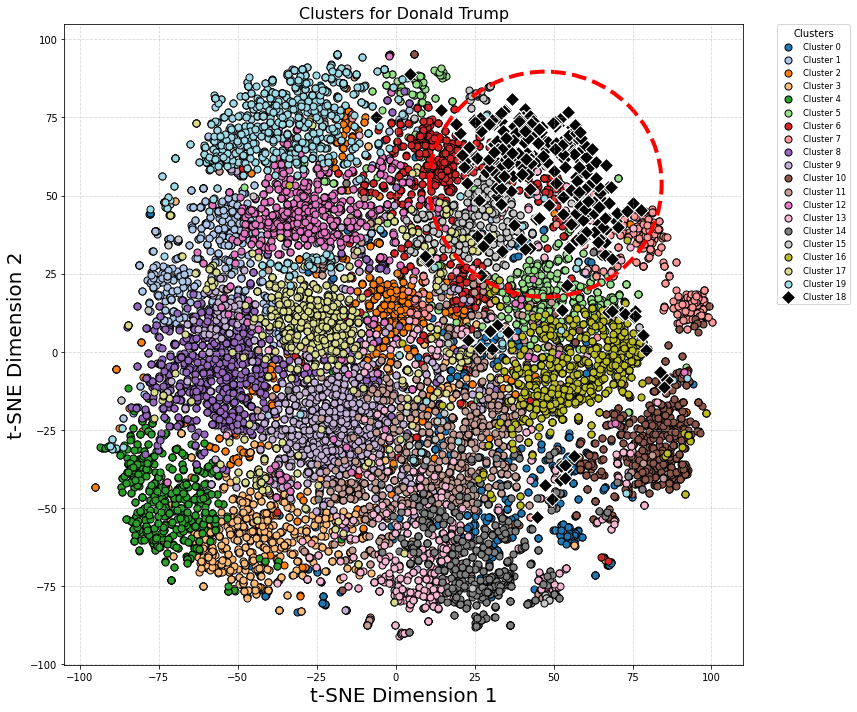

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

df = pd.read_pickle('precomputed_tsne_clusters_per_politician_fast.pkl').copy()

def generate_color_palette(n_clusters):
    cmap = plt.cm.get_cmap("tab20", n_clusters)
    return [cmap(i) for i in range(n_clusters)]

def visualize_clusters(df, person, n_clusters=20):
    person_df = df[df['Top1_Person'] == person]
    colors = generate_color_palette(n_clusters)
    plt.figure(figsize=(12, 10))
    for cluster in range(n_clusters):
        if cluster != 18:
            cluster_df = person_df[person_df['cluster'] == cluster]
            plt.scatter(cluster_df['tsne_1'], cluster_df['tsne_2'], label=f"Cluster {cluster}", color=colors[cluster], edgecolor='black', s=50)
    cluster_18_df = person_df[person_df['cluster'] == 18]
    plt.scatter(cluster_18_df['tsne_1'], cluster_18_df['tsne_2'], label="Cluster 18", color=colors[18], edgecolor='white', facecolor='black', s=100, marker='D')
    if not cluster_18_df.empty:
        x_mean, y_mean = cluster_18_df['tsne_1'].mean(), cluster_18_df['tsne_2'].mean()
        x_std, y_std = cluster_18_df['tsne_1'].std(), cluster_18_df['tsne_2'].std()
        ellipse = Ellipse((x_mean, y_mean), width=5*x_std, height=3*y_std, edgecolor='red', facecolor='none', linestyle='--', linewidth=4)
        plt.gca().add_patch(ellipse)
    plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0., fontsize='small')
    plt.title(f'Clusters for {person}', fontsize=16)
    plt.xlabel('t-SNE Dimension 1', fontsize=20)
    plt.ylabel('t-SNE Dimension 2', fontsize=20)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig('Cluster', dpi=70, bbox_inches='tight')
    plt.show()

politician = "Donald Trump"
visualize_clusters(df, politician)

### Sub-Cluster Visualization with Ideological Coloring  

This step zooms into a **specific cluster** of a given politician and colors the points based on a **conservative share scores** for news sources.  
The colormap ranges from blue (liberal-leaning) to red (conservative-leaning), enabling us to analyze how media ideological bias is distributed within that cluster. The code related to Figure 8. 


/tmp/ipykernel_1641681/3364159070.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['conservative_score'] = filtered_df['News Center'].map(harvard)


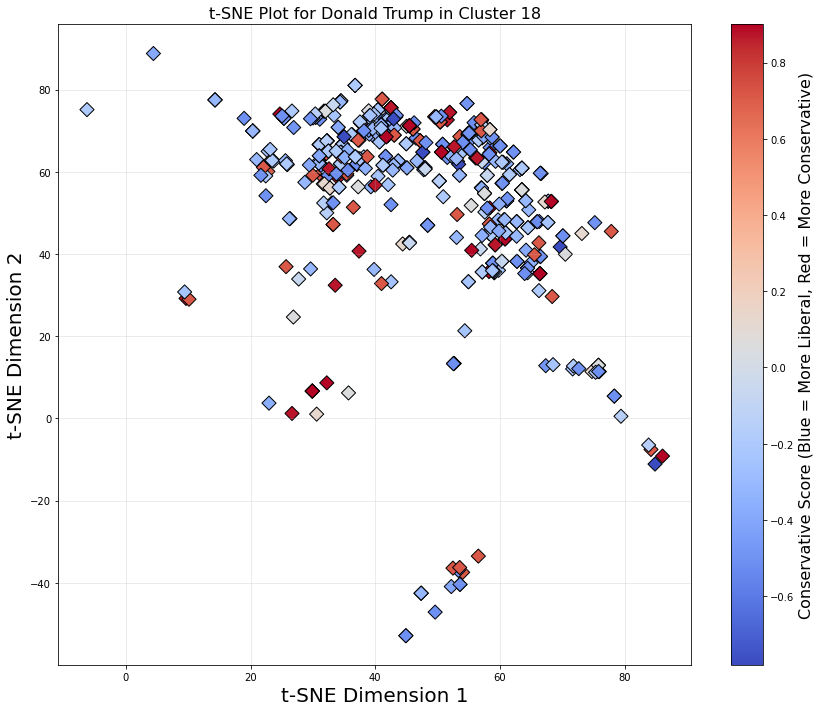

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

df = pd.read_pickle('precomputed_tsne_clusters_per_politician_fast.pkl').copy()

harvard = {
    'www.bbc.com': -0.31, 'www.nytimes.com': -0.53, 'www.huffpost.com': -0.78, 'www.washingtonpost.com': -0.51, 
    'www.wsj.com': 0.05, 'www.usnews.com': -0.20, 'time.com': -0.48, 'www.reuters.com': -0.20, 'www.cnn.com': -0.36, 
    'www.cbsnews.com': -0.31, 'www.latimes.com': -0.39, 'news.yahoo.com': -0.15, 'www.usatoday.com': -0.19, 
    'www.dailymail.co.uk': 0.71, 'www.cnbc.com': 0.12, 'www.csmonitor.com': -0.07, 'abcnews.go.com': -0.24, 
    'www.nbcnews.com': -0.50, 'www.foxnews.com': 0.87, 'www.newsmax.com': 0.9
}

def plot_cluster_for_politician(df, politician, cluster, harvard):
    filtered_df = df[(df['Top1_Person'] == politician) & (df['cluster'] == cluster)]
    if filtered_df.empty:
        print(f"No data found for politician '{politician}' in cluster '{cluster}'.")
        return
    filtered_df['conservative_score'] = filtered_df['News Center'].map(harvard)
    norm = plt.Normalize(vmin=min(harvard.values()), vmax=max(harvard.values()))
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(
        filtered_df['tsne_1'], filtered_df['tsne_2'], 
        c=filtered_df['conservative_score'], cmap='coolwarm', s=100, edgecolor='black', norm=norm, marker='D'
    )
    cbar = plt.colorbar(scatter)
    cbar.set_label('Conservative Score (Blue = More Liberal, Red = More Conservative)', fontsize=16)
    plt.title(f't-SNE Plot for {politician} in Cluster {cluster}', fontsize=16)
    plt.xlabel('t-SNE Dimension 1', fontsize=20)
    plt.ylabel('t-SNE Dimension 2', fontsize=20)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('Sub_Cluster', dpi=70, bbox_inches='tight')
    plt.show()

politician = "Donald Trump"
cluster = 18
plot_cluster_for_politician(df, politician, cluster, harvard)

### Effect of Smile Edit on Trump Photo in t-SNE  

Using embeddings and t-SNE, we track how adding a smile to a Trump photo shifts its position in embedding space. The new image is plotted alongside its closest matches from different news centers, showing how even a subtle facial change alters clustering and ideological proximity. This code related to Fiture 9. 


Cluster for Donald Trump with ID 196491: 18


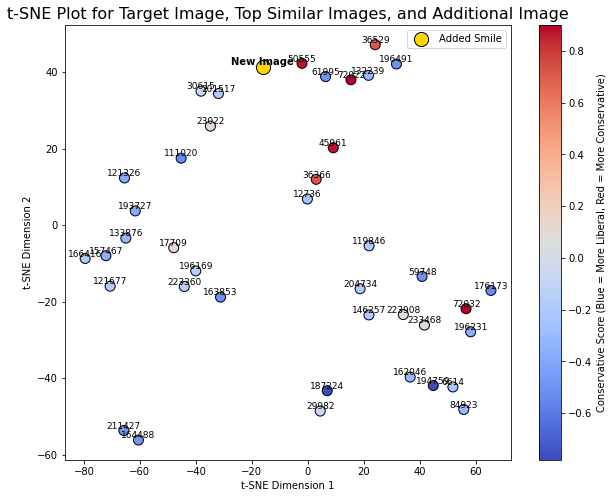

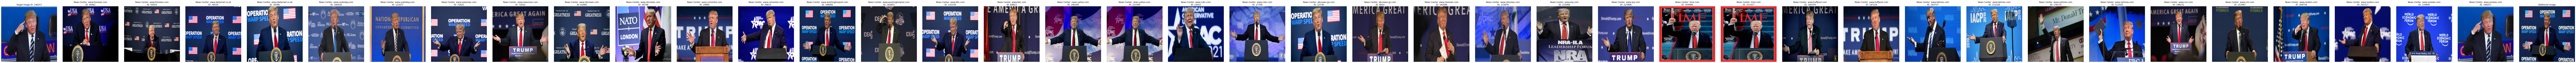

In [16]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.metrics.pairwise import euclidean_distances

df = pd.read_pickle('precomputed_tsne_clusters_per_politician_fast.pkl').copy()
image_folder = 'data/images_Polarization'

harvard = {'www.bbc.com': -0.31, 'www.nytimes.com': -0.53, 'www.huffpost.com': -0.78, 'www.washingtonpost.com': -0.51, 
           'www.wsj.com': 0.05, 'www.usnews.com': -0.20, 'time.com': -0.48, 'www.reuters.com': -0.20, 'www.cnn.com': -0.36, 
           'www.cbsnews.com': -0.31, 'www.latimes.com': -0.39, 'news.yahoo.com': -0.15, 'www.usatoday.com': -0.19, 
           'www.dailymail.co.uk': 0.71, 'www.cnbc.com': 0.12, 'www.csmonitor.com': -0.07, 'abcnews.go.com': -0.24, 
           'www.nbcnews.com': -0.50, 'www.foxnews.com': 0.87, 'www.newsmax.com': 0.9}

resnet101 = models.resnet101(pretrained=True)
resnet101.fc = torch.nn.Identity()
resnet101.eval()
resnet101 = resnet101.to('cuda' if torch.cuda.is_available() else 'cpu')

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def extract_resnet_embedding(image_path):
    image = Image.open(image_path).convert('RGB')
    image = preprocess(image).unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')
    with torch.no_grad():
        embedding = resnet101(image)
    return embedding.cpu().numpy().flatten()

def visualize_with_additional_image(df, politician, img_id, additional_image_path, top_n=2):
    target_row = df[(df['Top1_Person'] == politician) & (df['ID'] == img_id)]
    if target_row.empty:
        print(f"No image found for politician {politician} with ID {img_id}.")
        return
    cluster = target_row['cluster'].values[0]
    print(f"Cluster for {politician} with ID {img_id}: {cluster}")
    person_df = df[(df['Top1_Person'] == politician) & (df['cluster'] == cluster)]
    target_tsne_point = target_row[['tsne_1', 'tsne_2']].values.reshape(1, -1)
    selected_rows = pd.DataFrame()
    for news_center in person_df['News Center'].unique():
        news_center_df = person_df[person_df['News Center'] == news_center]
        if len(news_center_df) > 0:
            tsne_points = news_center_df[['tsne_1', 'tsne_2']].values
            distances = euclidean_distances(target_tsne_point, tsne_points).flatten()
            top_indices = np.argsort(distances)[:top_n]
            selected_rows = pd.concat([selected_rows, news_center_df.iloc[top_indices]])
    additional_embedding = extract_resnet_embedding(additional_image_path)
    all_embeddings = np.vstack([np.stack(selected_rows['embedding'].values), additional_embedding])
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(5, len(all_embeddings) - 1))
    tsne_embeddings = tsne.fit_transform(all_embeddings)
    selected_tsne_embeddings = tsne_embeddings[:-1]
    additional_tsne_embedding = tsne_embeddings[-1]
    plt.figure(figsize=(10, 8))
    conservative_scores = selected_rows['News Center'].map(harvard).values
    norm = plt.Normalize(vmin=min(harvard.values()), vmax=max(harvard.values()))
    scatter = plt.scatter(selected_tsne_embeddings[:, 0], selected_tsne_embeddings[:, 1], 
                          c=conservative_scores, cmap='coolwarm', edgecolor='black', norm=norm, s=100)
    for i, (x, y, img_id) in enumerate(zip(selected_tsne_embeddings[:, 0], selected_tsne_embeddings[:, 1], selected_rows['ID'])):
        plt.text(x, y, str(img_id), fontsize=9, ha='center', va='bottom', color='black')
    plt.scatter(additional_tsne_embedding[0], additional_tsne_embedding[1], 
                color='gold', edgecolor='black', s=200, label="Added Smile")
    plt.text(additional_tsne_embedding[0], additional_tsne_embedding[1], "New Image", fontsize=10, ha='center', va='bottom', fontweight='bold', color='black')
    cbar = plt.colorbar(scatter)
    cbar.set_label('Conservative Score (Blue = More Liberal, Red = More Conservative)')
    plt.title('t-SNE Plot for Target Image, Top Similar Images, and Additional Image', fontsize=16)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(loc='upper right')
    plt.show()
    base_image_path = os.path.join(image_folder, f"{img_id}.jpg")
    base_image = Image.open(base_image_path).resize((224, 224))
    additional_image = Image.open(additional_image_path).resize((224, 224))
    num_images = len(selected_rows) + 2
    fig, axes = plt.subplots(1, num_images, figsize=(5 * num_images, 5))
    axes[0].imshow(base_image)
    axes[0].set_title(f"Target Image ID: {img_id}")
    axes[0].axis('off')
    for i, (index, row) in enumerate(selected_rows.iterrows(), start=1):
        news_center = row['News Center']
        comparison_image_path = os.path.join(image_folder, f"{row['ID']}.jpg")
        comparison_image = Image.open(comparison_image_path).resize((224, 224))
        axes[i].imshow(comparison_image)
        axes[i].set_title(f"News Center: {news_center}\nID: {row['ID']}")
        axes[i].axis('off')
    axes[-1].imshow(additional_image)
    axes[-1].set_title("Additional Image")
    axes[-1].axis('off')
    plt.tight_layout()
    plt.show()

politician = "Donald Trump"
img_id = "196491"
additional_image_name = "Donald_Trump_with_smile_4"
additional_image_path = os.path.join("Counterfactuals", f"{additional_image_name}.jpg")
visualize_with_additional_image(df, politician, img_id, additional_image_path, top_n=1)

### Multi-Modal Grad-CAM  

This block loads the **trained multimodal model** and uses **Grad-CAM** to visualize how edits (e.g., adding a smile to Trump) shift the model’s attention across face and full-image features. This code related to Figure 7.

/home/jupyter-hoc_project/.local/lib/python3.9/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


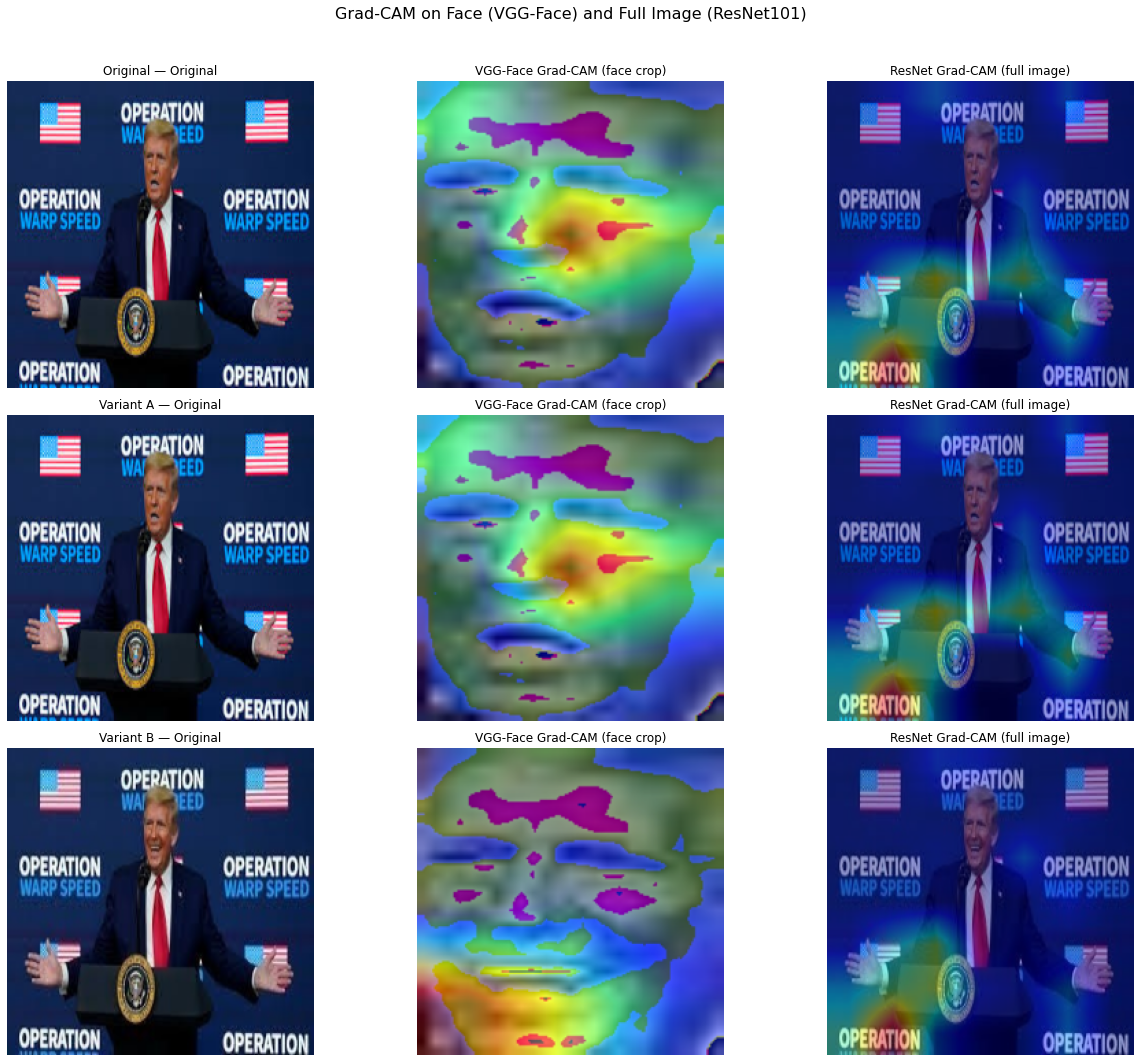

In [20]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import models, transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
from facenet_pytorch import InceptionResnetV1, MTCNN
import pandas as pd
from sklearn.preprocessing import LabelEncoder

MODEL_WEIGHTS_PATH = 'model/ML_Model.pth'
IMG_ORIG_DIR = 'data/images_Polarization'
IMG_STATIC_DIR = 'data/Counterfactuals'
PICKLE_PATH = 'cleaned_complete_data_Face_Verification_Info_Raady_MLModel.pkl'

image_id  = 196491
image_idd = 'Donald_Trump_4'
image_iddd= 'Donald_Trump_with_smile_4'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_resnet101_pretrained():
    if hasattr(models, 'ResNet101_Weights'):
        return models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
    return models.resnet101(pretrained=True)

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super().__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads
        self.values = nn.Linear(embed_size, embed_size, bias=False)
        self.keys = nn.Linear(embed_size, embed_size, bias=False)
        self.queries = nn.Linear(embed_size, embed_size, bias=False)
        self.fc_out = nn.Linear(embed_size, embed_size)
    def forward(self, values, keys, query):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]
        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(query)
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = queries.reshape(N, query_len, self.heads, self.head_dim)
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        attention = torch.softmax(energy / (self.embed_size ** 0.5), dim=3)
        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(N, query_len, self.heads * self.head_dim)
        return self.fc_out(out)

class ImprovedMultiModalModel(nn.Module):
    def __init__(self, num_person_categories, num_party_categories, num_topics, num_classes,
                 num_date_categories, embedding_dim_person=8, embedding_dim_party=2,
                 embedding_dim_date=4, num_attention_heads=8, window_size=32):
        super().__init__()
        self.face_vgg = InceptionResnetV1(pretrained='vggface2').eval()
        for p in list(self.face_vgg.parameters())[:-5]:
            p.requires_grad = False
        self.fc_vgg_1 = nn.Linear(512, 256)
        self.bn_vgg = nn.BatchNorm1d(256)
        self.dropout_vgg = nn.Dropout(0.3)
        self.person_embedding = nn.Embedding(num_person_categories, embedding_dim_person)
        self.party_embedding  = nn.Embedding(num_party_categories,  embedding_dim_party)
        self.date_embedding   = nn.Embedding(num_date_categories,   embedding_dim_date)
        self.fc_structured_proj = nn.Linear(embedding_dim_person + embedding_dim_party + num_topics + embedding_dim_date, 64)
        self.structured_attention = MultiHeadAttention(embed_size=64, heads=num_attention_heads)
        self.bn_structured = nn.BatchNorm1d(64)
        self.dropout_structured = nn.Dropout(0.4)
        self.fc_person_party_proj = nn.Linear(embedding_dim_person + embedding_dim_party, window_size)
        self.chunked_attention = MultiHeadAttention(embed_size=window_size, heads=num_attention_heads)
        resnet_pretrained = load_resnet101_pretrained()
        for p in list(resnet_pretrained.parameters())[:-10]:
            p.requires_grad = False
        self.features_resnet = nn.Sequential(*list(resnet_pretrained.children())[:-1])
        self.fc_resnet = nn.Linear(resnet_pretrained.fc.in_features, 512)
        self.bn_resnet = nn.BatchNorm1d(512)
        self.dropout_resnet = nn.Dropout(0.6)
        self.fc_out = nn.Linear(256 + 64 + 512, num_classes)
        self.dropout_out = nn.Dropout(0.5)
    def forward(self, resnet_img, face_img, person, party, topic_distribution, date):
        vgg_features = self.face_vgg(face_img)
        vgg_features = F.relu(self.bn_vgg(self.fc_vgg_1(vgg_features)))
        vgg_features = self.dropout_vgg(vgg_features)
        person_emb = self.person_embedding(person)
        party_emb  = self.party_embedding(party)
        date_emb   = self.date_embedding(date)
        structured = torch.cat((person_emb, party_emb, topic_distribution, date_emb), dim=1)
        structured_proj = F.relu(self.fc_structured_proj(structured))
        structured = self.structured_attention(structured_proj.unsqueeze(1),
                                               structured_proj.unsqueeze(1),
                                               structured_proj.unsqueeze(1)).squeeze(1)
        structured = F.relu(self.bn_structured(structured))
        structured = self.dropout_structured(structured)
        person_party_data = torch.cat((person_emb, party_emb), dim=1)
        person_party_proj = self.fc_person_party_proj(person_party_data).unsqueeze(1)
        vgg_chunks = vgg_features.view(vgg_features.size(0), 8, -1)
        attended_chunks = []
        for i in range(8):
            vgg_chunk = vgg_chunks[:, i, :].unsqueeze(1)
            att_out = self.chunked_attention(person_party_proj, vgg_chunk, vgg_chunk).squeeze(1)
            attended_chunks.append(att_out)
        attended_vgg = torch.cat(attended_chunks, dim=1)
        resnet_feats = self.features_resnet(resnet_img)
        resnet_feats = torch.flatten(resnet_feats, 1)
        resnet_feats = F.relu(self.bn_resnet(self.fc_resnet(resnet_feats)))
        resnet_feats = self.dropout_resnet(resnet_feats)
        combined = torch.cat((attended_vgg, structured, resnet_feats), dim=1)
        combined = self.dropout_out(combined)
        out = self.fc_out(combined)
        return out

class GradCAM:
    def __init__(self, model_module, target_layer):
        self.model = model_module
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.target_layer.register_forward_hook(self._save_activation)
        self.target_layer.register_backward_hook(self._save_gradient)
    def _save_activation(self, module, inp, out):
        self.activations = out
    def _save_gradient(self, module, gin, gout):
        self.gradients = gout[0]
    def __call__(self, x):
        self.model.eval()
        x.requires_grad_(True)
        out = self.model(x)
        score = out.view(out.size(0), -1).max(dim=1).values.sum()
        self.model.zero_grad()
        score.backward(retain_graph=True)
        if self.gradients is None or self.activations is None:
            raise RuntimeError("Gradients/activations not captured.")
        pooled_grad = torch.mean(self.gradients, dim=[0, 2, 3]) if self.gradients.dim()==4 else torch.mean(self.gradients, dim=0)
        acts = self.activations.detach()
        if acts.dim()==4:
            for i in range(acts.shape[1]):
                acts[:, i, :, :] *= pooled_grad[i]
            cam = torch.mean(acts, dim=1).squeeze()
        else:
            cam = acts.squeeze()
        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-10)
        return cam.cpu().numpy()

def preprocess_image(image_path, device):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    image = transform(image).unsqueeze(0)
    return image.to(device)

def preprocess_face(face_image, device):
    if isinstance(face_image, torch.Tensor):
        face = transforms.Resize((160, 160))(face_image)
    else:
        face = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])(face_image)
    face = face.unsqueeze(0)
    return face.to(device)

def find_last_conv_layer(module):
    last = None
    for m in module.modules():
        if isinstance(m, nn.Conv2d):
            last = m
    return last

df = pd.read_pickle(PICKLE_PATH)

person_encoder = LabelEncoder()
party_encoder  = LabelEncoder()
date_encoder   = LabelEncoder()
outlet_encoder = LabelEncoder()

df['Top1_Person_encoded'] = person_encoder.fit_transform(df['Top1_Person'])
df['Real Person Side_encoded'] = party_encoder.fit_transform(df['Real Person Side'])
df['Date_encoded'] = date_encoder.fit_transform(df['Date'])
df['News Center_encoded'] = outlet_encoder.fit_transform(df['News Center'])

num_person_categories = len(person_encoder.classes_)
num_party_categories  = len(party_encoder.classes_)
num_date_categories   = len(date_encoder.classes_)
num_classes           = len(outlet_encoder.classes_)
topic_cols = [c for c in df.columns if c.startswith('topic_')]
num_topics = len(topic_cols)

model = ImprovedMultiModalModel(
    num_person_categories=num_person_categories,
    num_party_categories=num_party_categories,
    num_topics=num_topics,
    num_classes=num_classes,
    num_date_categories=num_date_categories,
    embedding_dim_person=8,
    embedding_dim_party=2,
    embedding_dim_date=4,
    num_attention_heads=8
).to(device)

checkpoint = torch.load(MODEL_WEIGHTS_PATH, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

def visualize_gradcam(image_id, image_idd, image_iddd):
    img_paths = {
        "Original": os.path.join(IMG_ORIG_DIR, f"{image_id}.jpg"),
        "Variant A": os.path.join(IMG_STATIC_DIR, f"{image_idd}.jpg"),
        "Variant B": os.path.join(IMG_STATIC_DIR, f"{image_iddd}.jpg"),
    }
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    fig.suptitle("Grad-CAM on Face (VGG-Face) and Full Image (ResNet101)", fontsize=16)
    vgg_layer = find_last_conv_layer(model.face_vgg)
    resnet_layer = find_last_conv_layer(model.features_resnet)
    vgg_cam = GradCAM(model.face_vgg, vgg_layer)
    resnet_cam = GradCAM(model.features_resnet, resnet_layer)
    mtcnn = MTCNN(keep_all=False, device=device, thresholds=[0.4, 0.5, 0.6], min_face_size=15, factor=0.6)
    for i, (title_suffix, img_path) in enumerate(img_paths.items()):
        if not os.path.exists(img_path):
            continue
        original_img = Image.open(img_path).convert("RGB")
        face_img = mtcnn(original_img)
        input_image_resnet = preprocess_image(img_path, device)
        resnet_heatmap = resnet_cam(input_image_resnet)
        original_img_cv2 = cv2.imread(img_path)
        original_img_cv2 = cv2.resize(original_img_cv2, (224, 224))
        axes[i, 0].imshow(cv2.cvtColor(original_img_cv2, cv2.COLOR_BGR2RGB))
        axes[i, 0].set_title(f'{title_suffix} — Original')
        axes[i, 0].axis('off')
        if face_img is not None:
            input_image_vgg = preprocess_face(face_img, device)
            vgg_heatmap = vgg_cam(input_image_vgg)
            vgg_heatmap_resized = cv2.resize(vgg_heatmap, (224, 224))
            vgg_heatmap_colored = cv2.applyColorMap(np.uint8(255 * vgg_heatmap_resized), cv2.COLORMAP_JET)
            face_img_cv2 = face_img.permute(1, 2, 0).detach().cpu().numpy()
            face_img_cv2 = (face_img_cv2 * 255).astype(np.uint8)
            face_img_resized = cv2.resize(face_img_cv2, (224, 224))
            vgg_super = cv2.addWeighted(vgg_heatmap_colored, 0.4, face_img_resized, 0.6, 0)
            axes[i, 1].imshow(cv2.cvtColor(vgg_super, cv2.COLOR_BGR2RGB))
            axes[i, 1].set_title('VGG-Face Grad-CAM (face crop)')
            axes[i, 1].axis('off')
        else:
            axes[i, 1].axis('off')
        resnet_heatmap_resized = cv2.resize(resnet_heatmap, (224, 224))
        resnet_heatmap_colored = cv2.applyColorMap(np.uint8(255 * resnet_heatmap_resized), cv2.COLORMAP_JET)
        resnet_super = cv2.addWeighted(resnet_heatmap_colored, 0.4, original_img_cv2, 0.6, 0)
        axes[i, 2].imshow(cv2.cvtColor(resnet_super, cv2.COLOR_BGR2RGB))
        axes[i, 2].set_title('ResNet Grad-CAM (full image)')
        axes[i, 2].axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

visualize_gradcam(image_id, image_idd, image_iddd)


### Testing Expression Impact on Predictions  

This block uses the **trained multimodal model** to compare predictions for an original image versus edited variants (e.g., Trump with a smile). By examining how the **news outlet probability distribution** shifts across versions, we can see whether adding a smile changes how the model attributes the image to different outlets. This code related to Table 3.


In [18]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
from facenet_pytorch import InceptionResnetV1, MTCNN
import pandas as pd
from sklearn.preprocessing import LabelEncoder

MODEL_WEIGHTS_PATH = 'model/ML_Model.pth'
IMG_ORIG_DIR = 'data/images_Polarization'
IMG_STATIC_DIR = 'data/Counterfactuals'
PICKLE_PATH = 'cleaned_complete_data_Face_Verification_Info_Raady_MLModel.pkl'

image_id  = 196491
image_idd = 'Donald_Trump_4'
image_iddd= 'Donald_Trump_with_smile_4'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_resnet101_pretrained():
    if hasattr(models, 'ResNet101_Weights'):
        return models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
    return models.resnet101(pretrained=True)

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super().__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads
        self.values = nn.Linear(embed_size, embed_size, bias=False)
        self.keys = nn.Linear(embed_size, embed_size, bias=False)
        self.queries = nn.Linear(embed_size, embed_size, bias=False)
        self.fc_out = nn.Linear(embed_size, embed_size)

    def forward(self, values, keys, query):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]
        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(query)
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = queries.reshape(N, query_len, self.heads, self.head_dim)
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        attention = torch.softmax(energy / (self.embed_size ** 0.5), dim=3)
        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )
        return self.fc_out(out)

class ImprovedMultiModalModel(nn.Module):
    def __init__(self, num_person_categories, num_party_categories, num_topics, num_classes,
                 num_date_categories, embedding_dim_person=8, embedding_dim_party=2,
                 embedding_dim_date=4, num_attention_heads=8, window_size=32):
        super().__init__()
        self.face_vgg = InceptionResnetV1(pretrained='vggface2').eval()
        for p in list(self.face_vgg.parameters())[:-5]:
            p.requires_grad = False
        self.fc_vgg_1 = nn.Linear(512, 256)
        self.bn_vgg = nn.BatchNorm1d(256)
        self.dropout_vgg = nn.Dropout(0.3)
        self.person_embedding = nn.Embedding(num_person_categories, embedding_dim_person)
        self.party_embedding  = nn.Embedding(num_party_categories,  embedding_dim_party)
        self.date_embedding   = nn.Embedding(num_date_categories,   embedding_dim_date)
        self.fc_structured_proj = nn.Linear(embedding_dim_person + embedding_dim_party + num_topics + embedding_dim_date, 64)
        self.structured_attention = MultiHeadAttention(embed_size=64, heads=num_attention_heads)
        self.bn_structured = nn.BatchNorm1d(64)
        self.dropout_structured = nn.Dropout(0.4)
        self.fc_person_party_proj = nn.Linear(embedding_dim_person + embedding_dim_party, window_size)
        self.chunked_attention = MultiHeadAttention(embed_size=window_size, heads=num_attention_heads)
        resnet_pretrained = load_resnet101_pretrained()
        for p in list(resnet_pretrained.parameters())[:-10]:
            p.requires_grad = False
        self.features_resnet = nn.Sequential(*list(resnet_pretrained.children())[:-1])
        self.fc_resnet = nn.Linear(resnet_pretrained.fc.in_features, 512)
        self.bn_resnet = nn.BatchNorm1d(512)
        self.dropout_resnet = nn.Dropout(0.6)
        self.fc_out = nn.Linear(256 + 64 + 512, num_classes)
        self.dropout_out = nn.Dropout(0.5)

    def forward(self, resnet_img, face_img, person, party, topic_distribution, date):
        vgg_features = self.face_vgg(face_img)
        vgg_features = F.relu(self.bn_vgg(self.fc_vgg_1(vgg_features)))
        vgg_features = self.dropout_vgg(vgg_features)
        person_emb = self.person_embedding(person)
        party_emb  = self.party_embedding(party)
        date_emb   = self.date_embedding(date)
        structured = torch.cat((person_emb, party_emb, topic_distribution, date_emb), dim=1)
        structured_proj = F.relu(self.fc_structured_proj(structured))
        structured = self.structured_attention(structured_proj.unsqueeze(1),
                                               structured_proj.unsqueeze(1),
                                               structured_proj.unsqueeze(1)).squeeze(1)
        structured = F.relu(self.bn_structured(structured))
        structured = self.dropout_structured(structured)
        person_party_data = torch.cat((person_emb, party_emb), dim=1)
        person_party_proj = self.fc_person_party_proj(person_party_data).unsqueeze(1)
        vgg_chunks = vgg_features.view(vgg_features.size(0), 8, -1)
        attended_chunks = []
        for i in range(8):
            vgg_chunk = vgg_chunks[:, i, :].unsqueeze(1)
            att_out = self.chunked_attention(person_party_proj, vgg_chunk, vgg_chunk).squeeze(1)
            attended_chunks.append(att_out)
        attended_vgg = torch.cat(attended_chunks, dim=1)
        resnet_feats = self.features_resnet(resnet_img)
        resnet_feats = torch.flatten(resnet_feats, 1)
        resnet_feats = F.relu(self.bn_resnet(self.fc_resnet(resnet_feats)))
        resnet_feats = self.dropout_resnet(resnet_feats)
        combined = torch.cat((attended_vgg, structured, resnet_feats), dim=1)
        combined = self.dropout_out(combined)
        out = self.fc_out(combined)
        return out

transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

def preprocess_face(face_image, device):
    if isinstance(face_image, torch.Tensor):
        face = transforms.Resize((224, 224))(face_image)
    else:
        face = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])(face_image)
    face = face.unsqueeze(0)
    return face.to(device)

df = pd.read_pickle(PICKLE_PATH)

person_encoder = LabelEncoder()
party_encoder  = LabelEncoder()
date_encoder   = LabelEncoder()
outlet_encoder = LabelEncoder()

df['Top1_Person_encoded'] = person_encoder.fit_transform(df['Top1_Person'])
df['Real Person Side_encoded'] = party_encoder.fit_transform(df['Real Person Side'])
df['Date_encoded'] = date_encoder.fit_transform(df['Date'])
df['News Center_encoded'] = outlet_encoder.fit_transform(df['News Center'])

num_person_categories = len(person_encoder.classes_)
num_party_categories  = len(party_encoder.classes_)
num_date_categories   = len(date_encoder.classes_)
num_classes           = len(outlet_encoder.classes_)
topic_cols = [c for c in df.columns if c.startswith('topic_')]
num_topics = len(topic_cols)

model = ImprovedMultiModalModel(
    num_person_categories=num_person_categories,
    num_party_categories=num_party_categories,
    num_topics=num_topics,
    num_classes=num_classes,
    num_date_categories=num_date_categories,
    embedding_dim_person=8,
    embedding_dim_party=2,
    embedding_dim_date=4,
    num_attention_heads=8
).to(device)

checkpoint = torch.load(MODEL_WEIGHTS_PATH, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

mtcnn = MTCNN(keep_all=False, device=device, thresholds=[0.4, 0.5, 0.6], min_face_size=15, factor=0.6)

def predict_image(image_id, image_idd, image_iddd):
    record = df[df['ID'] == image_id]
    if record.empty:
        print(f"No record found for ID {image_id}")
        return
    true_news_center = record['News Center'].values[0]
    party_name = record['Real Person Side'].values[0]
    person_name = record['Top1_Person'].values[0]
    title = record['processed_title'].values[0] if 'processed_title' in record.columns else 'N/A'
    print(f"Image ID: {image_id}")
    print(f"True News Center: {true_news_center}")
    print(f"Party: {party_name}")
    print(f"Politician: {person_name}")
    print(f"Title: {title}")
    img_paths = {
        "Original": os.path.join(IMG_ORIG_DIR, f"{image_id}.jpg"),
        "Variant A": os.path.join(IMG_STATIC_DIR, f"{image_idd}.jpg"),
        "Variant B": os.path.join(IMG_STATIC_DIR, f"{image_iddd}.jpg"),
    }
    for title_suffix, path in img_paths.items():
        if not os.path.exists(path):
            print(f"\n[WARN] Missing image: {path}")
            continue
        original_img = Image.open(path).convert("RGB")
        face_img = mtcnn(original_img)
        if face_img is None:
            print(f"\nNo face detected in {title_suffix} image.")
            continue
        input_image_resnet = transform_resnet(original_img).unsqueeze(0).to(device)
        input_image_vgg = preprocess_face(face_img, device)
        person_tensor = torch.tensor([record['Top1_Person_encoded'].values[0]], dtype=torch.long, device=device)
        party_tensor  = torch.tensor([record['Real Person Side_encoded'].values[0]], dtype=torch.long, device=device)
        date_tensor   = torch.tensor([record['Date_encoded'].values[0]], dtype=torch.long, device=device)
        topic_distribution = torch.tensor(record[topic_cols].values, dtype=torch.float32, device=device)
        with torch.no_grad():
            output = model(input_image_resnet, input_image_vgg, person_tensor, party_tensor, topic_distribution, date_tensor)
            probabilities = F.softmax(output, dim=1).cpu().numpy().squeeze()
            pred_idx = int(probabilities.argmax())
            predicted_class = outlet_encoder.inverse_transform([pred_idx])[0]
        print(f"\nPrediction Probabilities for {title_suffix}:")
        order = probabilities.argsort()[::-1]
        for idx in order:
            news_center = outlet_encoder.inverse_transform([idx])[0]
            print(f"{news_center}: {probabilities[idx]*100:.4f}%")
        print(f"Predicted News Center: {predicted_class} (Probability: {probabilities.max()*100:.2f}%)")
        print(f"True News Center: {true_news_center}")

predict_image(image_id, image_idd, image_iddd)


Image ID: 196491
True News Center: www.washingtonpost.com
Party: Republican
Politician: Donald Trump
Title: Trump's embarrassing Four-Pinocchio claim about Florida and Ohio

Prediction Probabilities for Original:
www.washingtonpost.com: 30.9793%
www.cnbc.com: 15.0266%
www.latimes.com: 10.0010%
time.com: 7.7661%
www.newsmax.com: 7.1042%
news.yahoo.com: 5.0249%
www.nbcnews.com: 4.8426%
www.usatoday.com: 3.2727%
www.cnn.com: 2.9027%
www.dailymail.co.uk: 2.8947%
abcnews.go.com: 2.5973%
www.usnews.com: 1.6352%
www.nytimes.com: 1.2133%
www.foxnews.com: 1.1313%
www.csmonitor.com: 1.0350%
www.cbsnews.com: 0.6289%
www.huffpost.com: 0.6088%
www.wsj.com: 0.5861%
www.reuters.com: 0.5325%
www.bbc.com: 0.2170%
Predicted News Center: www.washingtonpost.com (Probability: 30.98%)
True News Center: www.washingtonpost.com

Prediction Probabilities for Variant A:
www.washingtonpost.com: 30.9793%
www.cnbc.com: 15.0266%
www.latimes.com: 10.0010%
time.com: 7.7661%
www.newsmax.com: 7.1042%
news.yahoo.com: 5.0